# Mahalanobis - Softmax - Trusted for IMDB, Movie Review and MNLI Datasets

In [1]:
import numpy as np
import torch

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install git+https://github.com/Julien2048/NLP_Project_OOD.git --quiet
!git clone https://github.com/Julien2048/NLP_Project_OOD
!pip install -r NLP_Project_OOD/requirements.txt --quiet

  Preparing metadata (setup.py) ... done
Cloning into 'NLP_Project_OOD'...
remote: Enumerating objects: 261, done.
remote: Total 261 (delta 0), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (261/261), 425.80 KiB | 1.81 MiB/s, done.
Resolving deltas: 100% (121/121), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.9 MB/s eta

In [4]:
%cd gdrive/MyDrive/NLP_Project_OOD/distilbert
!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/modeling_distilbert.py
!cp modeling_distilbert.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/

!rm /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/models/distilbert/
%cd ..

%cd transformers
!rm /usr/local/lib/python3.9/dist-packages/transformers/__init__.py
!cp __init__.py /usr/local/lib/python3.9/dist-packages/transformers/
%cd ../../..

/content/gdrive/MyDrive/NLP_Project_OOD/distilbert
/content/gdrive/MyDrive/NLP_Project_OOD
/content/gdrive/MyDrive/NLP_Project_OOD/transformers
/content/gdrive


In [6]:
from nlp_project.data_loader import IMDBDataset
from nlp_project.OOD_detector import Mahalanobis, MaxSoftmax, IRW
from nlp_project.metrics import ResultsOOD
from nlp_project.BERT_adaptation import DistilBertClassifier

## Load Classifier

In [7]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
model_prelogits = DistilBertClassifier(device=device, prelogits=True, path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_imdb_distilbert")
model_hidden_state = DistilBertClassifier(device=device, prelogits=False, path_pretrained_model="/content/gdrive/MyDrive/NLP_Project_OOD/models_trained/model_imdb_distilbert")

In [9]:
imdb_prelogits_train, imdb_logits_train = model_prelogits.load_prelogit_logit("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
imdb_prelogits_test, imdb_logits_test = model_prelogits.load_prelogit_logit("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

movie_review_prelogits_test, movie_review_logits_test = model_prelogits.load_prelogit_logit("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
mnli_prelogits_test, mnli_logits_test = model_prelogits.load_prelogit_logit( "mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
sst2_prelogits_test, sst2_logits_test = model_prelogits.load_prelogit_logit( "sst2", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
rte_prelogits_test, rte_logits_test = model_prelogits.load_prelogit_logit( "rte", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

In [10]:
imdb_hidden_state_train = model_hidden_state.load_hidden_layer("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
imdb_hidden_state_test = model_hidden_state.load_hidden_layer("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")

movie_review_hidden_state_test = model_hidden_state.load_hidden_layer("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
mnli_hidden_state_test = model_hidden_state.load_hidden_layer("mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
sst2_hidden_state_test = model_hidden_state.load_hidden_layer("sst2", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")
rte_hidden_state_test = model_hidden_state.load_hidden_layer("rte", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/hidden_layer/imdb-mr-mnli/")

## Computing OOD

### Mahalanobis Score

#### IMDB - Movie Review

Average value of cov_inv matrix : 2879008402.489122
Average distance between cov_inv*cov and identity matrix : 0.0005216314438634622
AUROC : 35.65 %


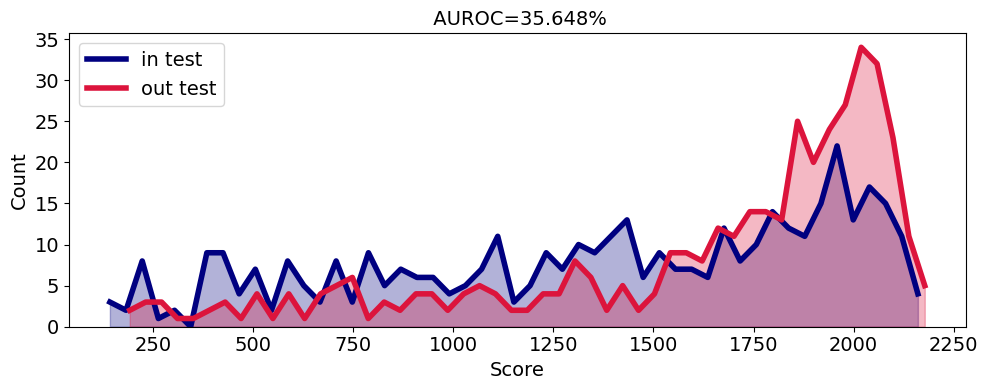

In [12]:
get_imdb = IMDBDataset()
imdb_train_labels, imdb_test_labels = get_imdb.load_labels("/content/gdrive/MyDrive/NLP_Project_OOD/data/imdb/")

maha_imdb_mr = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    movie_review_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mr, scores_imdb_mr = maha_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr)
results_imdb_mr()

#### IMDB - MNLI

Average value of cov_inv matrix : 2879008402.489122
Average distance between cov_inv*cov and identity matrix : 0.0005216314438634622
AUROC : 2.38 %


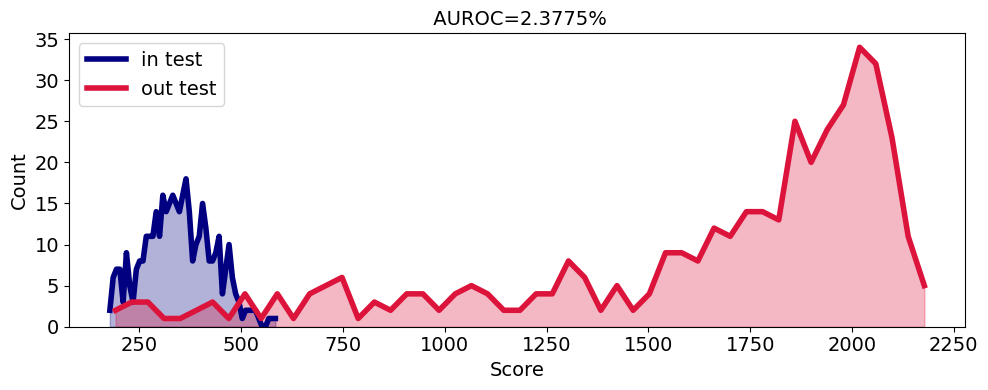

In [14]:
maha_imdb_mnli = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    mnli_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mnli, scores_imdb_mnli = maha_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli)
results_imdb_mnli()

#### IMDB - SST2

Average value of cov_inv matrix : 2879008402.489122
Average distance between cov_inv*cov and identity matrix : 0.0005216314438634622
AUROC : 2.87 %


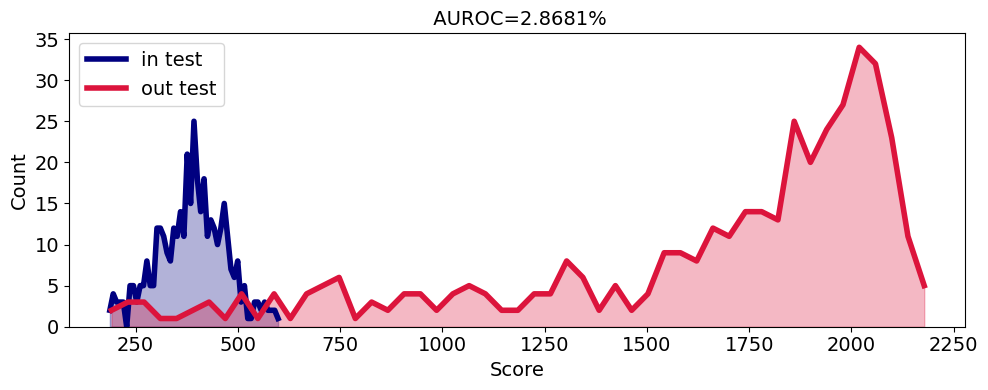

In [15]:
maha_imdb_sst2 = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    sst2_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_sst2, scores_imdb_sst2 = maha_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2)
results_imdb_sst2()

#### IMDB - RTE

Average value of cov_inv matrix : 2879008402.489122
Average distance between cov_inv*cov and identity matrix : 0.0005216314438634622
AUROC : 2.92 %


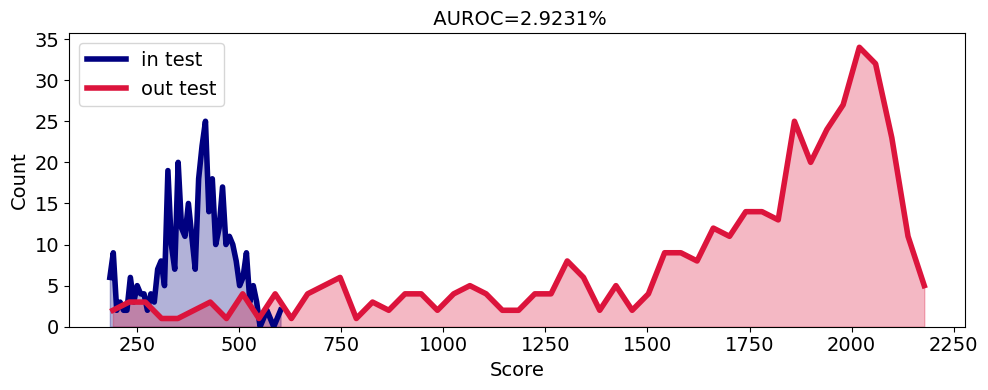

In [16]:
maha_imdb_rte = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    rte_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_rte, scores_imdb_rte = maha_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte)
results_imdb_rte()

### Maximum Softmax

In [17]:
from nlp_project.OOD_detector import MaxSoftmax, IRW

#### IMDB - Movie_review

AUROC : 60.79 %


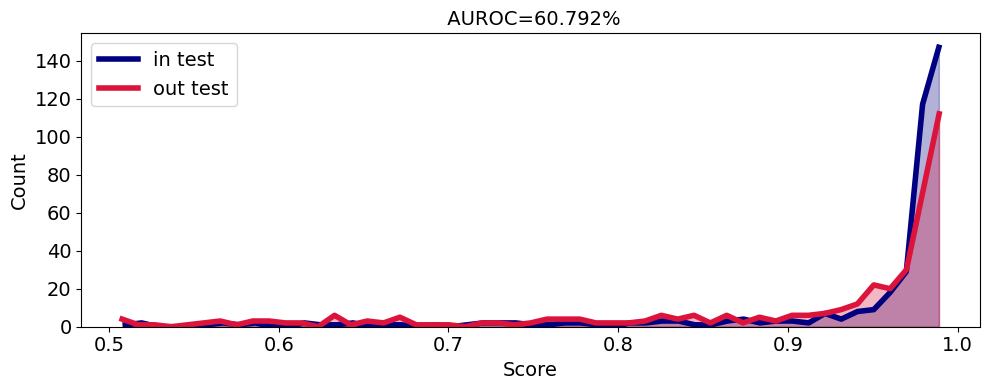

In [18]:
softmax_imdb_mr = MaxSoftmax(
    imdb_logits_test,
    movie_review_logits_test,
)
onehots_imdb_mr, scores_imdb_mr = softmax_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr)
results_imdb_mr()

#### IMDB - MNLI

AUROC : 91.77 %


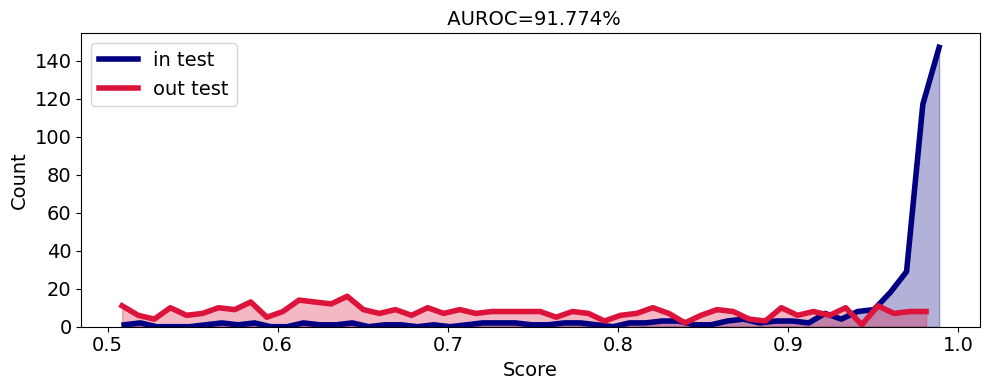

In [21]:
softmax_imdb_mnli = MaxSoftmax(
    imdb_logits_test,
    mnli_logits_test,
)

onehots_imdb_mnli, scores_imdb_mnli = softmax_imdb_mnli()
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli)
results_imdb_mnli()

#### IMDB - SST2

AUROC : 91.77 %


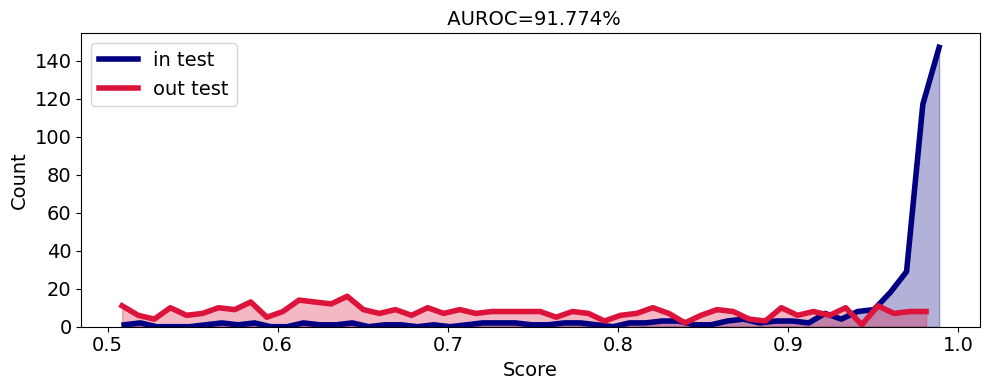

In [22]:
softmax_imdb_sst2 = MaxSoftmax(
    imdb_logits_test,
    mnli_logits_test,
)

onehots_imdb_sst2, scores_imdb_sst2 = softmax_imdb_sst2()
results_imdb_sst2 = ResultsOOD(onehots_imdb_sst2, scores_imdb_sst2)
results_imdb_sst2()

#### IMDB - RTE

AUROC : 91.77 %


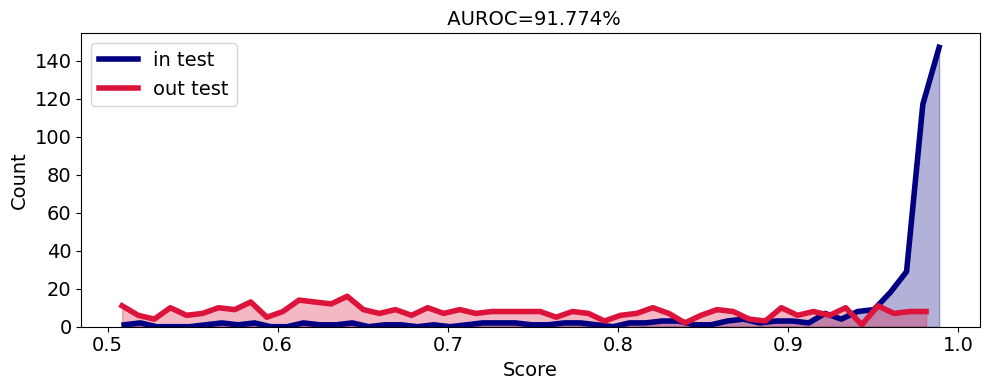

In [23]:
softmax_imdb_rte = MaxSoftmax(
    imdb_logits_test,
    mnli_logits_test,
)

onehots_imdb_rte, scores_imdb_rte = softmax_imdb_rte()
results_imdb_rte = ResultsOOD(onehots_imdb_rte, scores_imdb_rte)
results_imdb_rte()

###Trusted - IRW

#### IMDB - Movie Review

In [ ]:
trusted_imdb_mr = IRW(
    in_train=imdb_hidden_state_train,
    in_test=imdb_hidden_state_test,
    out_test=movie_review_hidden_state_test,
    n_dirs=1000
)
onehots_imdb_mr, scores_imdb_mr = trusted_imdb_mr()
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr)
results_imdb_mr()